In [124]:
%matplotlib inline

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

#import neural_network as nn
from sklearn.neural_network import MLPClassifier


import sqlite3
connection = sqlite3.connect("./database/bdfinal.sql")

In [ ]:
oneHotEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
labelEncoder = LabelEncoder()

## 1º Try - The most basic model possible

In [ ]:
query = "select teams.tmID, playerID, teams.year, playoff from players_teams join teams \
on teams.tmID = players_teams.tmID and teams.year = players_teams.year order by teams.year, teams.name ;"

dataframe = pd.read_sql(query, connection)
print(dataframe.head())

In [ ]:
query_test = "select teams.tmID as tmID, playerID, teams.year as year, playoff from players_teams join teams \
on teams.tmID = players_teams.tmID and teams.year = players_teams.year where teams.year = 10 order by teams.year, teams.name ;"
query_train = "select teams.tmID as tmID, playerID, teams.year as year, playoff from players_teams join teams \
on teams.tmID = players_teams.tmID and teams.year = players_teams.year where teams.year <> 10 order by teams.year, teams.name ;"

train_data = pd.read_sql(query_train,connection)

categorical_columns = ["tmID", "playerID"]

# work on categorical columns so that they can be used in the model
for col in categorical_columns:
    train_data[col] = labelEncoder.fit_transform(train_data[col].astype('str'))

train_inputs = train_data.iloc[:, :-1].values
train_labels = train_data.iloc[:, -1].values
    
test_data = pd.read_sql(query_test,connection)

# work on categorical columns so that they can be used in the model
for col in categorical_columns:
    test_data[col] = labelEncoder.fit_transform(test_data[col].astype('str'))
    
test_inputs = test_data.iloc[:, :-1].values
test_labels = test_data.iloc[:, -1].values


In [ ]:
clf = DecisionTreeClassifier(random_state=1)
clf.fit(train_inputs,train_labels)
print(clf.score(test_inputs,test_labels))
tree.plot_tree(clf)

### Logistic Regression 

In [ ]:
### Logistic Regression
logreg = LogisticRegression()
logreg.fit(train_inputs, train_labels)

y_pred = logreg.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

classification = classification_report(test_labels, y_pred)
print(f"Classification report:\n{classification}")

## 2º Try - Team Performance in Consideration

In [94]:
## create an empty dataframe without any column names, indices or data
df = pd.DataFrame()

## obtain the team IDS and year
team_ids = pd.read_sql("select tmID, year from teams", connection)
print(team_ids.head())

## iterate through each team and year
for index, row in team_ids.iterrows():
    ## obtain the team ID and year for each row
    team_id = row['tmID']
    year = row['year']
    
    query = "select tmID, year, avg(oRebounds), avg(dRebounds), avg(rebounds), avg(assists), avg(steals), avg(blocks), \
        avg(turnovers), avg(PF), avg(fgAttempted), avg(fgMade), avg(ftAttempted), avg(ftMade), avg(threeAttempted), avg(threeMade) \
        from players_teams where tmID = '" + team_id + "' and year = " + str(year) + ";"
        
    ## obtain the average stats for each team
    team_stats = pd.read_sql(query, connection)
    
    query = "select avg(weight), avg(height) from players_teams join players on players.bioID = players_teams.playerID \
        where tmID = '" + team_id + "' and year = " + str(year) + ";"
        
    ## obtain the average weight and height for each team
    team_weight_height = pd.read_sql(query, connection)
    
    ## add the average weight and height to the team stats
    team_stats['weight'] = team_weight_height['avg(weight)']
    team_stats['height'] = team_weight_height['avg(height)']
    
    # transform the NaN values to 0
    team_stats = team_stats.fillna(0)
    
    # include in the query the win and loss ratio
    query = "select tmID, year, won, lost, GP from teams where tmID = '" + team_id + "' and year = " + str(year) + ";"
    
    team_win_loss = pd.read_sql(query, connection)
    
    # obtain the win and loss ratio
    win_ratio = team_win_loss['won'] / team_win_loss['GP']
    loss_ratio = team_win_loss['lost'] / team_win_loss['GP']
    
    # add the win and loss ratio to the team stats
    team_stats['win_ratio'] = win_ratio
    team_stats['loss_ratio'] = loss_ratio
    
    query = "select count(pt.playerID) as num_player_awards from players_teams pt join awards_players ap on pt.playerID = ap.playerID \
        where pt.year = ap.year and pt.tmID = '" + team_id + "' and pt.year = " + str(year) + " group by pt.tmID, ap.year;"
        
    team_awards = pd.read_sql(query, connection)
    
    # add the number of player awards to the team stats
    team_stats['num_player_awards'] = team_awards['num_player_awards']
    
    # transform the NaN values to 0
    team_stats = team_stats.fillna(0)
    
    # obtain the number of coach awards
    query = "select count(coachID) as num_coach_awards from coaches join awards_players ap on coaches.coachID = ap.playerID \
        where coaches.year = ap.year and coaches.tmID = '" + team_id + "' and coaches.year = " + str(year) + " group by coaches.tmID, ap.year;"
        
    team_coach_awards = pd.read_sql(query, connection)
    
    # add the number of coach awards to the team stats
    team_stats['num_coach_awards'] = team_coach_awards['num_coach_awards']
    
    # transform the NaN values to 0
    team_stats = team_stats.fillna(0)
        
    query = "select tmID, year from teams where semis <> '' and tmID = '" + team_id + "' and year = " + str(year) + ";"
    semis = pd.read_sql(query, connection)
    
    # team reached semis
    if semis.empty:
        team_stats['semis'] = 0
    else:
        team_stats['semis'] = 1
        
    query = "select tmID, year from teams where finals <> '' and tmID = '" + team_id + "' and year = " + str(year) + ";"
    finals = pd.read_sql(query, connection)
    
    # team reached finals
    if finals.empty:
        team_stats['finals'] = 0
    else:
        team_stats['finals'] = 1
        
    query = "select playoff from teams where tmID = '" + team_id + "' and year = " + str(year) + ";"
    playoff = pd.read_sql(query, connection)
    
    # check if it's Y or N
    if playoff['playoff'][0] == 'Y':
        team_stats['playoff'] = 1
    else:
        team_stats['playoff'] = 0
        
    
    # append the stats to the dataframe
    df = df._append(team_stats, ignore_index=True)


  tmID  year
0  CHA     1
1  CLE     1
2  DET     1
3  HOU     1
4  IND     1
Index(['tmID', 'year', 'avg(oRebounds)', 'avg(dRebounds)', 'avg(rebounds)',
       'avg(assists)', 'avg(steals)', 'avg(blocks)', 'avg(turnovers)',
       'avg(PF)', 'avg(fgAttempted)', 'avg(fgMade)', 'avg(ftAttempted)',
       'avg(ftMade)', 'avg(threeAttempted)', 'avg(threeMade)', 'weight',
       'height', 'win_ratio', 'loss_ratio', 'num_player_awards',
       'num_coach_awards', 'semis', 'finals', 'playoff'],
      dtype='object')


In [95]:
# encode the categorical columns
categorical_columns = ["tmID"]
for col in categorical_columns:
    df[col] = labelEncoder.fit_transform(df[col].astype('str'))

# remove the rows that have year = 10
train_df = df[df.year != 10]

# remove the rows that have year <> 10
test_df = df[df.year == 10]

# create the training labels and inputs
train_inputs = train_df.iloc[:, :-1].values
print(train_inputs)
train_labels = train_df.iloc[:, -1].values

# create the testing labels and inputs
test_inputs = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values

[[ 1.          1.         23.46153846 ...  0.          0.
   0.        ]
 [ 3.          1.         25.46153846 ...  0.          1.
   0.        ]
 [ 5.          1.         26.23076923 ...  0.          0.
   0.        ]
 ...
 [16.          9.         17.75       ...  0.          1.
   1.        ]
 [17.          9.         24.28571429 ...  0.          0.
   0.        ]
 [19.          9.         22.625      ...  0.          0.
   0.        ]]


## Decision Tree Classifier

Accuracy: 0.8461538461538461
Precision: 0.8
Recall: 1.0
F1: 0.888888888888889
Confusion matrix:
[[3 2]
 [0 8]]


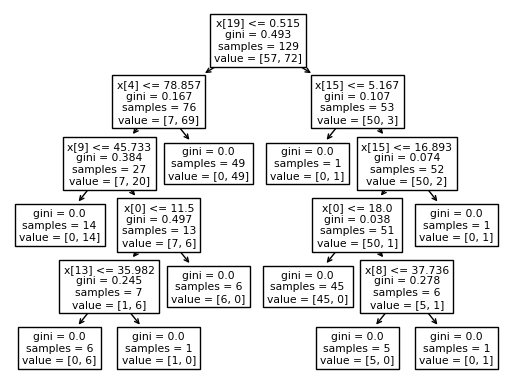

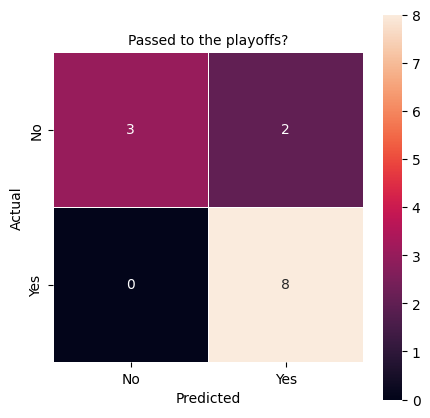

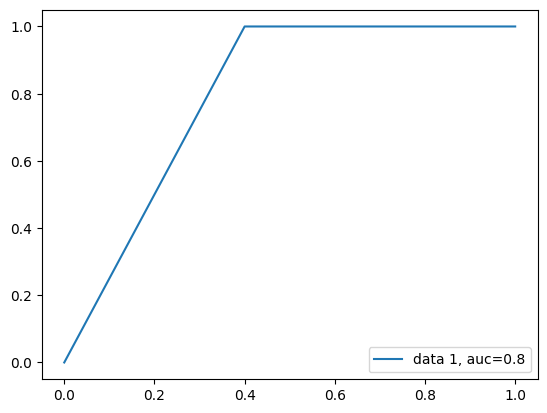

In [109]:
clf = DecisionTreeClassifier(random_state=1)
clf.fit(train_inputs,train_labels)


tree.plot_tree(clf)

# metrics for the decision tree
y_pred = clf.predict(test_inputs)
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred))
print("Recall:",metrics.recall_score(test_labels, y_pred))
print("F1:",metrics.f1_score(test_labels, y_pred))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'
plt.title(all_sample_title, size = 10)
plt.show()

# roc curve
y_pred_proba = clf.predict_proba(test_inputs)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  y_pred_proba)
auc = metrics.roc_auc_score(test_labels, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()



## Logistic Regression

Accuracy: 0.77
Precision: 0.73
Recall: 1.00
F1: 0.84


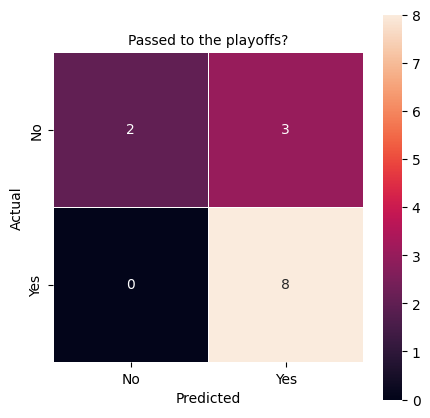

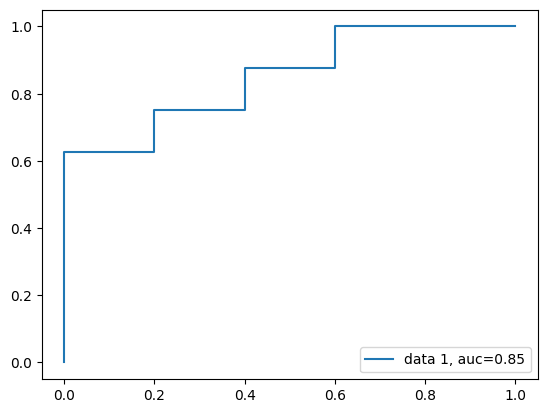

In [116]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(train_inputs, train_labels)

y_pred = logreg.predict(test_inputs)

# metrics for the logistic regression
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = metrics.precision_score(test_labels, y_pred)
print(f"Precision: {precision:.2f}")
recall = metrics.recall_score(test_labels, y_pred)
print(f"Recall: {recall:.2f}")
f1 = metrics.f1_score(test_labels, y_pred)
print(f"F1: {f1:.2f}")

# plot the confusion matrix
confusion = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'

plt.title(all_sample_title, size = 10)
plt.show()

# roc curve
y_pred_proba = logreg.predict_proba(test_inputs)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  y_pred_proba)
auc = metrics.roc_auc_score(test_labels, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Naive Bayes

Accuracy: 0.85
Precision: 1.00
Recall: 0.75
F1: 0.86


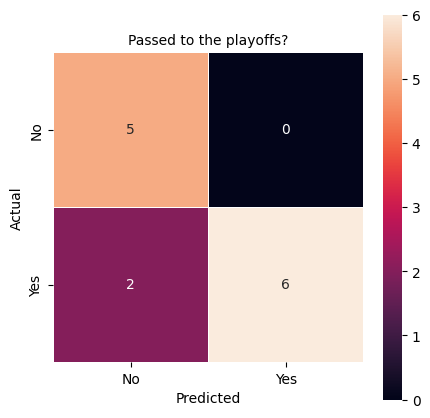

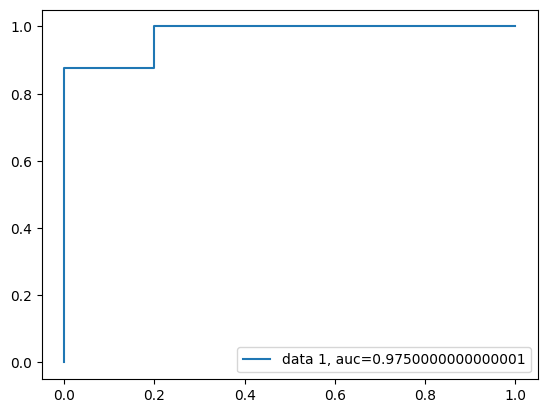

In [120]:
# Naive Bayes
gnb = GaussianNB()
gnb.fit(train_inputs, train_labels)

y_pred = gnb.predict(test_inputs)

# metrics for the naive bayes
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = metrics.precision_score(test_labels, y_pred)
print(f"Precision: {precision:.2f}")
recall = metrics.recall_score(test_labels, y_pred)
print(f"Recall: {recall:.2f}")
f1 = metrics.f1_score(test_labels, y_pred)
print(f"F1: {f1:.2f}")

# plot the confusion matrix
confusion = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'

plt.title(all_sample_title, size = 10)
plt.show()

# roc curve
y_pred_proba = gnb.predict_proba(test_inputs)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_labels,  y_pred_proba)
auc = metrics.roc_auc_score(test_labels, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()



## Suport Vector Machines

Accuracy: 0.69
Precision: 0.70
Recall: 0.88
F1: 0.78


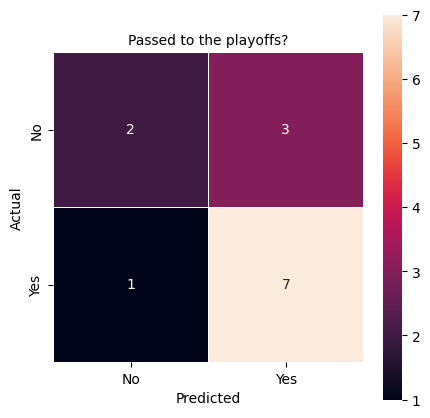

In [123]:
# SVM
svm = SVC(kernel='linear')
svm.fit(train_inputs, train_labels)

y_pred = svm.predict(test_inputs)

# metrics for the SVM
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = metrics.precision_score(test_labels, y_pred)
print(f"Precision: {precision:.2f}")
recall = metrics.recall_score(test_labels, y_pred)
print(f"Recall: {recall:.2f}")
f1 = metrics.f1_score(test_labels, y_pred)
print(f"F1: {f1:.2f}")

# plot the confusion matrix
confusion = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'

plt.title(all_sample_title, size = 10)
plt.show()


## Neural Network

In [125]:
# neural network
nn = MLPClassifier(hidden_layer_sizes=(5, 5), max_iter=1000)
nn.fit(train_inputs, train_labels)

y_pred = nn.predict(test_inputs)

# metrics for the neural network
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = metrics.precision_score(test_labels, y_pred)
print(f"Precision: {precision:.2f}")
recall = metrics.recall_score(test_labels, y_pred)
print(f"Recall: {recall:.2f}")
f1 = metrics.f1_score(test_labels, y_pred)
print(f"F1: {f1:.2f}")

Accuracy: 0.23
Precision: 0.33
Recall: 0.25
F1: 0.29
